# Clustering Feature Requests into Common Requests

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import nltk
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

% matplotlib inline

## Import and clean data

In [8]:
data = pd.read_csv('./data/feature_export.csv', usecols=[2,3],
                  names=['subject', 'description'],
                  header=0,
                  encoding='utf-8')

data = data.fillna('empty')
data.head()

,subject,description
0,Edit bank statement,"Hi Team,\n\nI need a healp please call me on t..."
1,Link a foreign supplier to a foreign currency ...,Hi \n\nWe have foreign supplier settle with di...
2,Edit User's Email Address?,"Good afternoon,\n\nIs there a way to edit a us..."
3,Allow only 3ds in stripe integration,Stripe informed Xero need to change Stripe int...
4,Vigilant Technologies,"Hi Support,\n\nPlease advise on the following:..."


In [46]:
# Output blocked for github.
"""
print "Example case we want to clean:"
print
print 
print data.iloc[2]['description']

"""

'\nprint "Example case we want to clean:"\nprint\nprint \nprint data.iloc[2][\'description\']\n\n'

In [11]:
train, test = train_test_split(data, test_size=0.1, random_state=23)
test.to_csv('test_data.csv', encoding='utf-8')

In [249]:
data['description'] = data['description'].str.replace(r'([a-z0-9_\.-]+)@([\da-z\.-]+)\.([a-z\.]{2,6})', '') # Removes emails

In [250]:
data['description'] = data['description'].str.replace(r'<(.*?)\>', '') # Needs punct to clean

In [251]:
data['description'] = data['description'].str.replace(r'[^\w\s]', '') 

In [252]:
data['description'] = data['description'].str.replace(r'www[a-z]+', '')

In [253]:
data['description'] = data['description'].str.replace(r'http[a-z]+', '')

In [254]:
data['description'] = data['description'].str.replace(r'https[a-z]+', '')

In [255]:
data['description'] = data['description'].str.replace(r'supportxerocom', '')

In [256]:
data['description'] = data['description'].str.replace(r'\d', '') # removes numbers eg phone numbers

In [257]:
data['description'] = data['description'].str.lower().str.split()

In [259]:
# Remove stopwords from text using NLTK.
stop = stopwords.words('english')
stop.append('hello')
stop.append('hi')
stop.append('dear')
stop.append('sir')
stop.append('sirs')
stop.append('thank')
stop.append('facebook')
stop.append('twitter')
stop.append('linkedin') # Newly added

In [260]:
data['description'] = data['description'].apply(lambda x: [item for item in x if item not in stop])

In [258]:
# Stem words for better model performance
stemmer = SnowballStemmer("english")
data['description'] = data['description'].apply(lambda x: [stemmer.stem(y) for y in x])

In [261]:
print data.iloc[2]['description']

[u'good', u'afternoon', u'way', u'edit', u'user', u'email', u'address', u'realiz', u'delet', u'readd', u'dont', u'want', u'go', u'hassl', u'edit', u'sincer', u'heather', u'coti', u'event', u'coordin', u'hr', u'social', u'media', u'product', u'ambassador', u'ex', u'like', u'us', u'follow', u'us', u'sign', u'newslett', u'join', u'us', u'culinari', u'tour', u'itali']


In [262]:
#data.to_csv('./data/cleaned_feature.csv',
#           encoding='utf-8')

In [12]:
cleaned = pd.read_csv('./data/final_feature.csv', usecols=[1],
                     header=0)

cleaned = cleaned.fillna('empty')

cleaned.head()

,description
0,team need healp pleas call
1,foreign supplier settl differ foreign currenc ...
2,good afternoon way edit user email address rea...
3,stripe inform xero need chang stripe integr on...
4,support pleas advis follow tri connect dbs dir...


In [13]:
#train, test = train_test_split(cleaned, test_size=0.1)
#test.to_csv('test_data.csv')

# K-Means Clustering

In [14]:
# Setup Vector
vectorizer = TfidfVectorizer(max_df=0.9,
                            min_df=2)
X = vectorizer.fit_transform(cleaned['description'])

In [15]:
X.shape

(2380, 3117)

Even by setting min_df=2 we drop the # of features from 13,000 to 4175. This saves on a lot of text cleaning.

In [16]:
true_k = 8 ## Randomly set to 8. Play around with clusters at later stage
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


print("\n")
print("Prediction")

Y = vectorizer.transform(["invoice needs bigger logo"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["bank transaction doesn't have abiliy to edit"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["report with custom running balance"])
prediction = model.predict(Y)
print(prediction)

Top terms per cluster:
Cluster 0:  would  custom  item  way  bill  like  enter  possibl  order  need
Cluster 1:  xero  client  account  email  pleas  imag  use  regard  would  user
Cluster 2:  transact  bank  account  reconcil  feed  rule  code  statement  xero  show
Cluster 3:  invoic  custom  sale  email  way  quot  send  xero  number  client
Cluster 4:  version  iphon  app  os  model  languag  usernam  ui  organis  name
Cluster 5:  payment  invoic  batch  bank  await  account  bill  show  supplier  way
Cluster 6:  email  ani  intend  messag  confidenti  inform  recipi  may  pleas  attach
Cluster 7:  report  run  show  month  date  custom  xero  would  way  get


Prediction
[0]
[2]
[7]


In [18]:
k_means_labels = model.labels_
k_means_labels

array([1, 0, 1, ..., 3, 0, 0])

In [19]:
unique, counts = np.unique(k_means_labels, return_counts=True)
dict(zip(unique, counts))

{0: 691, 1: 488, 2: 221, 3: 389, 4: 39, 5: 140, 6: 186, 7: 226}

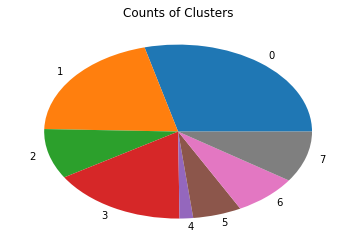

In [20]:
plt.pie(counts, labels=unique)
plt.title('Counts of Clusters')
plt.show()

In [27]:
data['labels'] = k_means_labels
data.to_csv('labelled.csv', encoding='utf-8')

# Hierarchical Clustering

In [288]:
from sklearn.cluster import AgglomerativeClustering

In [289]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=8)

In [290]:
result_clustering = clustering.fit(X.toarray())

In [291]:
cluster_labels = clustering.labels_

In [292]:
cluster_labels

array([3, 3, 3, ..., 0, 3, 3], dtype=int64)

In [293]:
unique, counts = np.unique(cluster_labels, return_counts=True)
dict(zip(unique, counts))

{0: 563, 1: 58, 2: 84, 3: 1143, 4: 173, 5: 36, 6: 167, 7: 156}

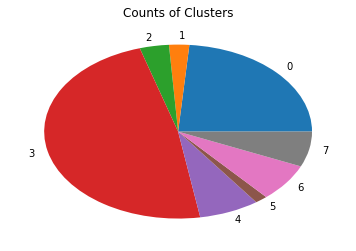

In [294]:
plt.pie(counts, labels=unique)
plt.title('Counts of Clusters')
plt.show()

# Non-negative Matrix Factorisation

The data in the form of a TF-IDF vector is naturally no negative as it's essentially just the word frequencies in Cases.

In [313]:
def display_topics(model, feature_names, top_words):
    """
    Function to print the top words of a given topic given a model
    """
    for topic_idx, topic in enumerate(model.components_):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-top_words - 1:-1]])

In [314]:
from sklearn.decomposition import NMF

In [318]:
nmf = NMF(n_components= 8,
          alpha=0.1)

In [319]:
nmf.fit(X)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [320]:
tfidf_feature_names = vectorizer.get_feature_names()
display_topics(nmf, tfidf_feature_names, top_words=15)

Topic 0:
xero client would file regard like use user access pleas help know possibl kind want
Topic 1:
email ani intend messag inform recipi confidenti pleas may attach copi contain receiv error notifi
Topic 2:
invoic custom payment sale send way date quot creat number email paid pay approv show
Topic 3:
report show run date month balanc custom get includ age period year see total sheet
Topic 4:
version app iphon ui os model languag usernam organis name devic deivc sent engb android
Topic 5:
account bank transact payment reconcil feed statement rule balanc credit show import code want card
Topic 6:
item line code descript inventori enter field add track would one default price column sale
Topic 7:
order purchas bill supplier number way approv alphabet date enter sale creat po deliveri month
